# **Intro:**


White blood cells are the backbone of our Immune system, they work to fight off pathogens in the body every minute to keep us healthy. There are different types of white blood cells that serve unique purposes, from killing off bacteria and parasites to manufacturing antibody proteins. It is important for medical practitioners and research scientists to identify the different cell types to find irregularities in white blood cell levels. In this notebook, we constructed and compared the performance and accuracy of a few classifiers in identifying white blood cell types. We decided to compare the performance of a decision tree, convolutional neural network, and a vision transformer.

The dataset we used is a collection of normal peripheral white blood cells images called Raabin-WBC containing about 40,000 images of white blood cells and color spots. The images are of 5 classes with each corresponding to a different type of white blood cell, which are Basophil, Lymphocyte, Monocyte, Eosinophil, and Neutrophil. We found this dataset to be of high quality not only due to the high resolution images captured by diverse microscope and camera setups, but because every type of cell is precisely labeled by two microbiology experts as well. The dataset came prepared with one training set and two testing sets, we will mainly be using the first TestA to evaluate the accuracy of our models.

First we load the raw datasets, since it came with a separate training and testing set, there is no need for us to split the data.

In [2]:
# Dataloader
import os
import PIL
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.cuda.amp import GradScaler, autocast
import timm
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from torch.utils.data import WeightedRandomSampler
from collections import Counter


# Load raw datasets first (no transforms yet)
raw_train_dataset = datasets.ImageFolder(root='dataset/Train')
raw_testA_dataset = datasets.ImageFolder(root='dataset/TestA')
raw_testB_dataset = datasets.ImageFolder(root='dataset/Test-B')

testA_loader = DataLoader(raw_testA_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count() // 2)
testB_loader = DataLoader(raw_testB_dataset, batch_size=64, shuffle=False, num_workers=os.cpu_count() // 2)

Now, to show just how unevenly these datasets are distributed, lets graph them visually:

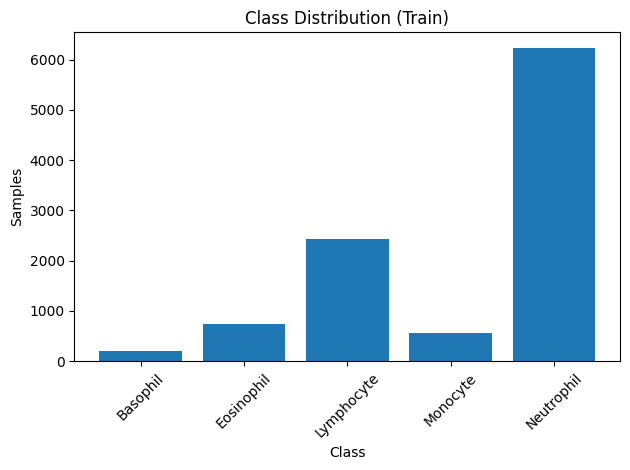

In [3]:
# Plot distribution
def plot_class_distribution(dataset, title):
    class_counts = Counter([label for _, label in dataset])
    labels = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.bar(labels, counts)
    plt.xticks(labels, [dataset.classes[i] for i in labels], rotation=45)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Samples")
    plt.tight_layout()
    plt.show()

plot_class_distribution(raw_train_dataset, "Class Distribution (Train)")

Since there is a pretty significantly uneven class distribution, we make a sampler function with balanced class weights to ensure a more even distribution:


In [4]:
def make_balanced_sampler(dataset):
    class_counts = Counter([label for _, label in dataset])
    class_weights = {cls: 1.0 / count for cls, count in class_counts.items()}
    weights = [class_weights[label] for _, label in dataset]
    return WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)

# **Models**

**Decision Tree**

In [5]:
# Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.decomposition import PCA
from torch.utils.data import Subset



#The following makes sure the given image is transformed before feeding into the model.
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
raw_train_dataset.transform = transform

balanced_sampler = make_balanced_sampler(raw_train_dataset)
balanced_indices = list(balanced_sampler)  # Get the indices from the sampler
balanced_train_dataset = Subset(raw_train_dataset, balanced_indices)




#this following function gets features and labels from a given dataset. It also flattens each image into a 1D array.
def get_features_labels(dataset):
    features = []
    labels =[]
    for image, label in dataset:
        features.append(image.view(-1).numpy())
        labels.append(label)
    return np.array(features), np.array(labels)

X, y = get_features_labels(balanced_train_dataset)
print("Original feature shape:", X.shape)

#split data into training and test sets (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)




#Apply PCA to reduce dimensions:
pca = PCA(n_components=100, random_state=42)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
print("Shape after PCA:", X_train.shape)




#htrain dataset on the Decision Tree classifier:
dt = DecisionTreeClassifier(random_state=42, class_weight="balanced")
dt.fit(X_train, y_train)

#predict on the test set:
y_pred = dt.predict(X_test)




#evaluate accuracy on the test set:
accuracy = accuracy_score(y_test, y_pred)
print("Decision Tree test accuracy: {:.2f}%".format(accuracy*100))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=raw_train_dataset.classes))

Original feature shape: (10175, 49152)
Shape after PCA: (8140, 100)
Decision Tree test accuracy: 87.91%

Classification Report:
               precision    recall  f1-score   support

    Basophil       0.99      1.00      0.99       406
  Eosinophil       0.87      0.92      0.89       409
  Lymphocyte       0.80      0.84      0.82       389
    Monocyte       0.89      0.96      0.93       448
  Neutrophil       0.83      0.66      0.73       383

    accuracy                           0.88      2035
   macro avg       0.88      0.87      0.87      2035
weighted avg       0.88      0.88      0.88      2035



**Convoluted Neural Network**

In [5]:
# CNN


Vision Transformer**

In [ ]:
# Vision Transformer
IMG_SIZE = 224

vit_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # adjust for grayscale
])

train_dataset = datasets.ImageFolder(root='dataset/Train', transform=vit_transform)
testA_dataset = datasets.ImageFolder(root='dataset/TestA', transform=vit_transform)
testB_dataset = datasets.ImageFolder(root='dataset/Test-B', transform=vit_transform)

# Split trainingdata into training and validation sets
train_size = int(0.85 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_ds, val_ds = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, num_workers=os.cpu_count() // 2)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, num_workers=os.cpu_count() // 2)

# # Load pretrained ViT
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=5)
# model = timm.create_model('vit_tiny_patch16_224', pretrained=True, num_classes=5)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

# Get class indices from the dataset
class_indices = [label for _, label in train_ds]

# Compute weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(class_indices), y=class_indices)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Define loss with class weights and adam optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Dynamic scaler to prevent underflow and speeds up training
scaler = torch.amp.GradScaler()

# Begin training
best_val_acc = 0.0
EPOCHS = 5

# For visualization
train_losses = []
val_accuracies = []
train_accuracies = []


for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        try:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            with torch.amp.autocast('cuda' if torch.cuda.is_available() else 'cpu'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # udate loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        except PIL.UnidentifiedImageError as e:
            print(f"Skipping corrupted image: {e}")
            continue

    avg_train_loss = running_loss / total
    train_acc = correct / total

    # Store train metrics
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            _, preds = outputs.max(1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_loss /= val_total
    val_acc = val_correct / val_total
    val_accuracies.append(val_acc)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_vit_model.pth")

    print(f'Epoch {epoch+1}/{EPOCHS}, '
          f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

def evaluate_vit(model, loader, name):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    print(f"{name} Accuracy: {correct / total:.4f}")

def evaluate_vit_detailed(model, loader, name):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print(f"\n{name} Classification Report:\n")
    print(classification_report(all_labels, all_preds, target_names=testA_dataset.classes))

# Load best model
model.load_state_dict(torch.load("best_vit_model.pth"))

# Evaluate
evaluate_vit(model, testA_loader, "TestA")
evaluate_vit_detailed(model, testA_loader, "TestA")

plt.figure(figsize=(10, 4))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


/Users/carter/anaconda3/lib/python3.11/site-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(


# **Conclusion:**


Looking at this data.......